In [1]:
import numpy as np
import time
from functools import partial
from pyscf import gto, scf
import matplotlib.pyplot as plt 
import matplotlib

import jax
jax.config.update("jax_enable_x64", True)

from jaxopt import BacktrackingLineSearch, HagerZhangLineSearch, BFGS, LBFGS
from jax import lax
import jax.numpy as jnp
from jax import grad, jit, random

In [2]:
# Define molecule and basis set
mol = gto.Mole()
mol = gto.Mole()
mol.atom = [
    # ["C", (-1.2949, 0.1300, 0.0000)],
    # ["C", (-0.0524, -0.6481, 0.0000)],
    # ["C", (1.1861, 0.1335, 0.0000)],
    # ["C", (2.4275, -0.6455, 0.0000)],
    # ["C", (3.6749, 0.1330, 0.0000)],
    # ["C", (4.9183, -0.6457, 0.0000)],
    # ["O", (-2.5245, -0.6457, 0.0000)],
    # ["O", (1.1866, 1.5146, 0.0000)],
    # ["O", (2.4280, -2.0265, 0.0000)],
    # ["O", (3.6748, 1.5142, 0.0000)],
    # ["O", (4.9173, -2.0262, 0.0000)],
    # ["O", (-1.2950, 1.5148, 0.0000)],
    # ["H", (-2.5266, 0.1301, 0.0000)],
    # ["H", (-0.0522, -1.7265, 0.0000)],
    # ["H", (1.1864, -0.9448, 0.0000)],
    # ["H", (1.1873, 2.0946, 0.8847)],
    # ["H", (1.1873, 2.0946, -0.8847)],
    # ["H", (2.4278, -2.6062, 0.8841)],
    # ["H", (2.4278, -2.6062, -0.8841)],
    # ["H", (3.6752, 2.0943, 0.8842)],
    # ["H", (3.6752, 2.0943, -0.8842)],
    # ["H", (4.9179, -2.6057, 0.8846)],
    # ["H", (4.9179, -2.6057, -0.8846)],
    # ["H", (-1.2953, 2.0949, 0.8840)]  # <-- Only one of the two enantiomeric Hs retained
    
    ["C", (-4.311, 2.521, -0.004)],
    ["C", (-3.416, 3.749, 0.023)],
    ["H", (-4.217, 1.948, 0.924)],
    ["H", (-4.054, 1.865, -0.841)],
    ["H", (-5.359, 2.818, -0.113)],
    ["C", (-1.944, 3.366, 0.164)],
    ["H", (-3.716, 4.394, 0.857)],
    ["H", (-3.563, 4.323, -0.900)],
    ["C", (-1.054, 4.595, 0.249)],
    ["H", (-1.635, 2.756, -0.693)],
    ["H", (-1.801, 2.757, 1.064)],
    ["H", (-1.146, 5.211, -0.651)],
    ["H", (-0.005, 4.298, 0.351)],
    ["H", (-1.317, 5.211, 1.115)]
    
    # ["C", (-4.301, 2.339, 0.081)],
    # ["C", (-3.707, 3.724, -0.107)],
    # ["H", (-4.018, 1.919, 1.052)],
    # ["H", (-3.958, 1.655, -0.702)],
    # ["H", (-5.394, 2.385, 0.037)],
    # ["C", (-2.189, 3.697, -0.049)],
    # ["H", (-4.090, 4.394, 0.670)],
    # ["H", (-4.028, 4.130, -1.073)],
    # ["H", (-1.841, 3.323, 0.919)],
    # ["H", (-1.786, 4.705, -0.189)],
    # ["H", (-1.778, 3.054, -0.834)]

    # ['O', (0.0, 0.0, 0.0)],
    # ['H', (0.0, -0.757, 0.587)],
    # ['H', (0.0, 0.757, 0.587)] 
    # ['O', (3.0, 0.0, 0.0)],
    # ['H', (3.0, -0.757, 0.587)],                                                                                                                       
    # ['H', (3.0, 0.757, 0)]

    # ['O', (0.0, 0.0, 0.0)],
    # ['H', (0.0, -0.757, 0.587)],
    # ['H', (0.0, 0.757, 0.587)]
    
    # ['C', (0.000000, 0.000000, 0.000000)],
    # ['H', (0.000000, 0.000000, 1.089000)],
    # ['H', (1.026719, 0.000000, -0.363000)],
    # ['H', (-0.513360, -0.889165, -0.363000)],
    # ['F', (-0.513360, 0.889165, -0.363000)]

    # ['N', (0.000000, 0.000000, 0.000000)],
    # ['H', (0.937700, 0.000000, -0.381600)],
    # ['H', (-0.468850, 0.812990, -0.381600)],
    # ['H', (-0.468850, -0.812990, -0.381600)]

    # ["C", (-2.818, 1.201, -0.000)],
    # ["H", (-3.183, 1.602, 0.948)],
    # ["H", (-3.182, 0.179, -0.126)],
    # ["H", (-3.183, 1.821, -0.822)],
    # ["H", (-1.726, 1.201, -0.000)]

    # ['C', (0.000000, 0.000000, -0.601100)],
    # ['C', (0.000000, 0.000000, 0.601100)],
    # ['H', (0.000000, 0.000000, -1.664500)],
    # ['H', (0.000000, 0.000000, 1.664500)]

    # ['C', (0.000000, 0.000000, 0.669500)],
    # ['C', (0.000000, 0.000000, -0.669500)],
    # ['H', (0.923000, 0.000000, 1.231000)],
    # ['H', (-0.923000, 0.000000, 1.231000)],
    # ['H', (0.923000, 0.000000, -1.231000)],
    # ['H', (-0.923000, 0.000000, -1.231000)]

    # ['C', (0.000000, 0.000000, 0.756400)],
    # ['C', (0.000000, 0.000000, -0.756400)],
    # ['H', (1.026719, 0.000000, 1.150700)],
    # ['H', (-0.513360, -0.889165, 1.150700)],
    # ['H', (-0.513360, 0.889165, 1.150700)],
    # ['H', (1.026719, 0.000000, -1.150700)],
    # ['H', (-0.513360, -0.889165, -1.150700)],
    # ['H', (-0.513360, 0.889165, -1.150700)]

    # ['C', (0.000000, 0.000000, 0.000000)],
    # ['O', (0.000000, 0.000000, 1.208000)],
    # ['H', (0.945221, 0.000000, -0.340000)],
    # ['H', (-0.945221, 0.000000, -0.340000)]

    #  ['C', ( 0.000,  0.000,  0.000)],
    #  ['C', ( 1.540,  0.000,  0.000)],
    #  ['C', ( 3.080,  1.000,  0.000)],
    #  ['C', ( 4.620,  0.000,  0.000)],
    #  ['C', ( 6.160,  1.000,  0.000)],
    #  ['C', ( 7.700,  0.000,  0.000)],
    #  ['C', ( 9.240,  1.000,  0.000)],
    #  ['C', (10.780,  0.000,  0.000)],
    #  ['C', (12.320,  1.000,  0.000)],
    #  ['C', (13.860,  0.000,  0.000)],
    #  ['C', (15.400,  1.000,  0.000)],
    #  ['C', (16.940,  0.000,  0.000)],
    #  ['C', (18.480,  1.000,  0.000)],
    #  ['C', (20.020,  0.000,  0.000)],
    #  ['C', (21.560,  1.000,  0.000)],
    #  ['C', (23.100,  0.000,  0.000)],
    #  ['C', (24.640,  1.000,  0.000)],
    #  ['C', (26.180,  0.000,  0.000)],
    #  ['C', (27.720,  1.000,  0.000)],
    #  ['C', (29.260,  0.000,  0.000)],
    #  ['C', (30.800,  1.000,  0.000)],
    #  ['C', (32.340,  0.000,  0.000)],
    #  ['C', (33.880,  1.000,  0.000)],
    #  ['C', (35.420,  0.000,  0.000)],
    #  ['C', (36.960,  1.000,  0.000)],
    #  ['C', (38.500,  0.000,  0.000)],
    #  ['C', (40.040,  1.000,  0.000)],
    #  ['C', (41.580,  0.000,  0.000)],
    #  ['C', (43.120,  1.000,  0.000)],
    #  ['C', (44.660,  0.000,  0.000)],
    #  ['C', (46.200,  1.000,  0.000)],
    #  ['C', (47.740,  0.000,  0.000)],
    #  ['C', (49.280,  1.000,  0.000)],
    #  ['C', (50.820,  0.000,  0.000)],
    #  ['C', (52.360,  1.000,  0.000)],
    #  ['C', (53.900,  0.000,  0.000)],
    #  ['C', (55.440,  1.000,  0.000)],
    #  ['C', (56.980,  0.000,  0.000)],
    #  ['C', (58.520,  1.000,  0.000)],
    #  ['C', (60.060,  0.000,  0.000)],
    # # C1 (x=0.00, y=0.00)
    #  ['H', ( 0.000,  0.940,  0.940)],
    #  ['H', ( 0.000, -0.940, -0.940)],
    #  # C2 (1.54,0.00)
    #  ['H', ( 1.540,  0.940,  0.940)],
    #  ['H', ( 1.540, -0.940, -0.940)],
    #  # C3 (3.08,1.00)
    #  ['H', ( 3.080,  1.940,  0.940)],
    #  ['H', ( 3.080,  0.060, -0.940)],
    #  # C4 (4.62,0.00)
    #  ['H', ( 4.620,  0.940,  0.940)],
    #  ['H', ( 4.620, -0.940, -0.940)],
    #  # C5
    #  ['H', ( 6.160,  1.940,  0.940)],
    #  ['H', ( 6.160,  0.060, -0.940)],
    #  # C6
    #  ['H', ( 7.700,  0.940,  0.940)],
    #  ['H', ( 7.700, -0.940, -0.940)],
    #  # C7
    #  ['H', ( 9.240,  1.940,  0.940)],
    #  ['H', ( 9.240,  0.060, -0.940)],
    #  # C8
    #  ['H', (10.780,  0.940,  0.940)],
    #  ['H', (10.780, -0.940, -0.940)],
    #  # C9
    #  ['H', (12.320,  1.940,  0.940)],
    #  ['H', (12.320,  0.060, -0.940)],
    #  # C10
    #  ['H', (13.860,  0.940,  0.940)],
    #  ['H', (13.860, -0.940, -0.940)],
    #  # C11
    #  ['H', (15.400,  1.940,  0.940)],
    #  ['H', (15.400,  0.060, -0.940)],
    #  # C12
    #  ['H', (16.940,  0.940,  0.940)],
    #  ['H', (16.940, -0.940, -0.940)],
    #  # C13
    #  ['H', (18.480,  1.940,  0.940)],
    #  ['H', (18.480,  0.060, -0.940)],
    #  # C14
    #  ['H', (20.020,  0.940,  0.940)],
    #  ['H', (20.020, -0.940, -0.940)],
    #  # C15
    #  ['H', (21.560,  1.940,  0.940)],
    #  ['H', (21.560,  0.060, -0.940)],
    #  # C16
    #  ['H', (23.100,  0.940,  0.940)],
    #  ['H', (23.100, -0.940, -0.940)],
    #  # C17
    #  ['H', (24.640,  1.940,  0.940)],
    #  ['H', (24.640,  0.060, -0.940)],
    #  # C18
    #  ['H', (26.180,  0.940,  0.940)],
    #  ['H', (26.180, -0.940, -0.940)],
    #  # C19
    #  ['H', (27.720,  1.940,  0.940)],
    #  ['H', (27.720,  0.060, -0.940)],
    #  # C20
    #  ['H', (29.260,  0.940,  0.940)],
    #  ['H', (29.260, -0.940, -0.940)],
    #  # C21
    #  ['H', (30.800,  1.940,  0.940)],
    #  ['H', (30.800,  0.060, -0.940)],
    #  # C22
    #  ['H', (32.340,  0.940,  0.940)],
    #  ['H', (32.340, -0.940, -0.940)],
    #  # C23
    #  ['H', (33.880,  1.940,  0.940)],
    #  ['H', (33.880,  0.060, -0.940)],
    #  # C24
    #  ['H', (35.420,  0.940,  0.940)],
    #  ['H', (35.420, -0.940, -0.940)],
    #  # C25
    #  ['H', (36.960,  1.940,  0.940)],
    #  ['H', (36.960,  0.060, -0.940)],
    #  # C26
    #  ['H', (38.500,  0.940,  0.940)],
    #  ['H', (38.500, -0.940, -0.940)],
    #  # C27
    #  ['H', (40.040,  1.940,  0.940)],
    #  ['H', (40.040,  0.060, -0.940)],
    #  # C28
    #  ['H', (41.580,  0.940,  0.940)],
    #  ['H', (41.580, -0.940, -0.940)],
    #  # C29
    #  ['H', (43.120,  1.940,  0.940)],
    #  ['H', (43.120,  0.060, -0.940)],
    #  # C30
    #  ['H', (44.660,  0.940,  0.940)],
    #  ['H', (44.660, -0.940, -0.940)],
    #  # C31
    #  ['H', (46.200,  1.940,  0.940)],
    #  ['H', (46.200,  0.060, -0.940)],
    #  # C32
    #  ['H', (47.740,  0.940,  0.940)],
    #  ['H', (47.740, -0.940, -0.940)],
    #  # C33
    #  ['H', (49.280,  1.940,  0.940)],
    #  ['H', (49.280,  0.060, -0.940)],
    #  # C34
    #  ['H', (50.820,  0.940,  0.940)],
    #  ['H', (50.820, -0.940, -0.940)],
    #  # C35
    #  ['H', (52.360,  1.940,  0.940)],
    #  ['H', (52.360,  0.060, -0.940)],
    #  # C36
    #  ['H', (53.900,  0.940,  0.940)],
    #  ['H', (53.900, -0.940, -0.940)],
    #  # C37
    #  ['H', (55.440,  1.940,  0.940)],
    #  ['H', (55.440,  0.060, -0.940)],
    #  # C38
    #  ['H', (56.980,  0.940,  0.940)],
    #  ['H', (56.980, -0.940, -0.940)],
    #  # C39
    #  ['H', (58.520,  1.940,  0.940)],
    #  ['H', (58.520,  0.060, -0.940)],
    #  # C40 (x=60.06, y=0.00)
    #  ['H', (60.060,  0.940,  0.940)],
    #  ['H', (60.060, -0.940, -0.940)],
    
    #  # Extra terminal H to make CH3 at both ends
    #  ['H', (-0.940,  0.000,  0.000)],   # on C1 side, along -x
    #  ['H', (61.000,  0.000,  0.000)],   # on C40 side, along +x
]
mol.unit = "angstrom"  # Explicitly specify angstroms
mol.basis = 'cc-pVDZ'
mol.build()

ao = mol.nao
Ne = mol.nelectron
occ_o = Ne // 2

# SCF calculation
mf = scf.RHF(mol)
energy = mf.kernel()
nuclear_repulsion_energy = mol.energy_nuc()
print(f"Nuclear Repulsion Energy: {nuclear_repulsion_energy:.6f} Hartree")
print(f"Electron energy: {energy - nuclear_repulsion_energy:.6f} Hartree")
print("Number of basis functions:", ao)

# Output one-electron integrals (overlap matrix, kinetic energy matrix, etc.)
S = mol.intor('int1e_ovlp')
T = mol.intor('int1e_kin')
V = mol.intor('int1e_nuc')
G = mol.intor('int2e')

H=T+V

converged SCF energy = -157.309330637949
Nuclear Repulsion Energy: 131.173669 Hartree
Electron energy: -288.483000 Hartree
Number of basis functions: 106


In [3]:
# Convert one-electron integrals to float32 JAX arrays
S = jnp.array(S, dtype=jnp.float32)
T = jnp.array(T, dtype=jnp.float32)
V = jnp.array(V, dtype=jnp.float32)
H = jnp.array(H, dtype=jnp.float32)

# Convert two-electron integrals to float32 JAX array
G = jnp.array(G, dtype=jnp.float32)

# Also cast nuclear repulsion energy if you use it with JAX
nuclear_repulsion_energy = jnp.float32(nuclear_repulsion_energy)

In [4]:
# Constants
times = []

energies_buf = jnp.zeros((500,))
constraints_buf = jnp.zeros((500,))
energies_buf_lbfgs = jnp.zeros((5000,))
constraints_buf_lbfgs = jnp.zeros((5000,))

# Compute the energy
@jax.jit
def compute_energy(x, JK, H, S):
    C = jnp.reshape(x, (ao, occ_o))
    P = 2.0 * (C @ C.T)
    G = jnp.einsum('lk,ijkl->ij', P, JK, optimize='greedy') - 0.5 * jnp.einsum('lk,ilkj->ij', P, JK, optimize='greedy')
    e1 = jnp.einsum('ji,ij->', P, H, optimize='greedy')
    e2 = jnp.einsum('ji,ij->', P, G, optimize='greedy')
    energy = 0.5 * (2 * e1 + e2)
    return energy

@jax.jit
def constraint_mat(x, S):
    C = jnp.reshape(x, (ao, occ_o))
    return C.T @ S @ C - jnp.eye(occ_o)

@jax.jit
def c_norm(c):
    return jnp.linalg.norm(c, ord='f')

@jax.jit
def compute_loss(x, JK, H, S, mu=1.0, Lam=jnp.zeros((occ_o, occ_o))):
    energy = compute_energy(x, JK, H, S)
    c = constraint_mat(x, S)
    # 0.5*mu*||c||_F^2 + <Lam, c>
    pen = jnp.sum(c * c) * (0.5 / mu) - jnp.sum(Lam * c)
    return energy + pen

# Pre-create grad fn to keep JIT 
grad_wrt_x = jax.jit(jax.grad(lambda x, JK, H, S, mu, lam: compute_loss(x, JK, H, S, mu, lam)))

# Compute the gradient
@jax.jit
def compute_gradient(x, JK, H, S, mu=1.0, lam=jnp.zeros((occ_o,occ_o))):
    return grad_wrt_x(x, JK, H, S, mu, lam)

@jax.jit
def loss_and_grad(x, JK, H, S, mu=1.0, lam=jnp.zeros((occ_o,occ_o))):
    return jax.value_and_grad(compute_loss)(x, JK, H, S, mu, lam)
    

@jax.jit
def armijo_line_search(x_curr, d_curr, loss_curr, grad_curr, JK, H, S, mu, lam,
                       alpha0=0.05, c1=1e-4, max_steps=100):
    """JAX Armijo backtracking with cap."""
    
    def init_state():
        xn = x_curr + alpha0 * d_curr
        ln = compute_loss(xn, JK, H, S, mu, lam)
        return dict(alpha=alpha0, x=xn, loss=ln, k=0)

    def cond_fn(st):
        # Need sufficient decrease: f(x+αd) <= f(x) + c1*α*g^T d
        rhs = loss_curr + c1 * st['alpha'] * jnp.dot(grad_curr, d_curr)
        bad = st['loss'] > rhs
        keep = jnp.logical_and(bad, st['k'] < max_steps)
        return keep

    def body_fn(st):
        new_alpha = 0.5 * st['alpha']
        xn = x_curr + new_alpha * d_curr
        ln = compute_loss(xn, JK, H, S, mu, lam)
        return dict(alpha=new_alpha, x=xn, loss=ln, k=st['k'] + 1)

    st0 = init_state()
    stf = lax.while_loop(cond_fn, body_fn, st0)
    return stf['x'], stf['loss'], stf['alpha']


@jax.jit
def run_secant_phase(x_init, constraint0, adapt_tol0, koeff, mu0, lam0, JK, H, S,
                     target_constraint=1e-2):

    def outer_cond(state):
        return c_norm(state['constraint']) > target_constraint
    
    def inner_cond(inner_state):
        grad_norm = jnp.linalg.norm(inner_state['grad'])
        not_done = jnp.logical_and(grad_norm > inner_state['adapt_tol'],
                                   jnp.logical_and(inner_state['step_norm'] > 1e-4, inner_state['iter'] < 500))
        return not_done
 
    def inner_body(inner_state):
        x_curr = inner_state['x']
        grad_curr = inner_state['grad']
        d_curr = inner_state['d']
        alpha = inner_state['alpha']
        mu = inner_state['mu']
        lam = inner_state['lam']

        # Ensure descent: if g^T d >= 0, restart with steepest descent
        dot_gd = jnp.dot(grad_curr, d_curr)
        d_curr = lax.cond(dot_gd >= -1e-12*jnp.linalg.norm(grad_curr)*jnp.linalg.norm(d_curr),
                          lambda _: -grad_curr, lambda _: d_curr, operand=None)

        loss_curr = compute_loss(x_curr, JK, H, S, mu, lam)

        x_next = x_curr + alpha * d_curr
        loss_next = compute_loss(x_next, JK, H, S, mu, lam)

        factor = 1e-4 * jnp.dot(grad_curr, d_curr)
        x_next, loss_next, alpha_used = armijo_line_search(x_curr, d_curr, loss_curr, grad_curr, JK, H, S, mu, lam, alpha0=alpha)        

        # Update position
        grad_next = compute_gradient(x_next, JK, H, S, mu, lam)

        # Secant step calculations
        s_k = x_next - x_curr
        step_norm = jnp.linalg.norm(s_k)
        y_k = grad_next - grad_curr
        s_k_sqr = jnp.dot(s_k, s_k)

        # Adaptive rho_k
        theta_k = 6.0 * (loss_curr - loss_next) + 3.0 * jnp.dot(grad_curr + grad_next, s_k)
        
        # rho_k = 1 if s_k_sqr <= 1 else 0
        rho_k = lax.cond(
            s_k_sqr <= 1.0,
            lambda _: 1.0,
            lambda _: 0.0,
            operand=None
        )

        theta_pos = jnp.maximum(theta_k, 0.0)
        y_k_mod = y_k + (rho_k * theta_pos / s_k_sqr) * s_k

        # Compute beta
        numerator1 = jnp.dot(grad_next, y_k_mod)
        numerator2 = 0.05 * jnp.dot(grad_next, s_k)
        denominator = jnp.dot(d_curr, y_k_mod)

        beta = lax.cond(
            denominator != 0.0,
            lambda _: jnp.maximum(numerator1 / denominator, 0.0) - numerator2 / denominator,
            lambda _: 0.0,
            operand=None
        )

        energy = compute_energy(x_next, JK, H, S)
        constraint = c_norm(constraint_mat(x_next, S))

        # Append to buffers
        energies_updated = lax.dynamic_update_slice_in_dim(inner_state['energies'], energy[None], inner_state['iter'], axis=0)
        constraints_updated = lax.dynamic_update_slice_in_dim(inner_state['constraints'], constraint[None], inner_state['iter'], axis=0)
        
        # Update direction and position
        d_next = -grad_next + beta * d_curr
        alpha = 0.75 * step_norm / jnp.linalg.norm(d_curr)

        return {
            'x': x_next,
            'step_norm': step_norm,
            'grad': grad_next,
            'd': d_next,
            'alpha': alpha,
            'y_k': y_k,
            'iter': inner_state['iter'] + 1,
            'mu': mu,
            'lam': lam,
            'adapt_tol': inner_state['adapt_tol'],
            'energies': energies_updated,
            'constraints': constraints_updated
        }


    def outer_body(state):
        # Initialize inner state
        grad_curr = compute_gradient(state['x'], JK, H, S, state['mu'], state['lam'])
        adapt_tol0 = 0.5 * jnp.exp(state['koeff'] * c_norm(state['constraint']))
        
        inner_state = {
            'x': state['x'],
            'step_norm': jnp.inf,
            'grad': grad_curr,
            'd': -grad_curr,
            'alpha': 0.05,
            'y_k': jnp.ones_like(state['x']),
            'iter': state['iter'],
            'mu': state['mu'],
            'lam': state['lam'],
            'adapt_tol': adapt_tol0,
            'energies': state['energies'],
            'constraints': state['constraints']
        }

        final_inner = lax.while_loop(inner_cond, inner_body, inner_state)

        # Update constraint and multipliers
        x_new = final_inner['x']
        c_new   = constraint_mat(x_new, S)

        mu_new = state['mu'] * 0.5
        lam_new = state['lam'] - c_new / state['mu']

        return {
            'x': x_new,
            'constraint': c_new,
            'mu': mu_new,
            'lam': lam_new,
            'adapt_tol': adapt_tol0,
            'koeff': state['koeff'],
            'iter': final_inner['iter'],
            'energies': final_inner['energies'],
            'constraints': final_inner['constraints'],
        }

    outer_state = {
        'x': x_init,
        'constraint': constraint0,
        'mu': mu0,
        'lam': lam0,
        'adapt_tol': adapt_tol0,
        'koeff': koeff,
        'iter': 0,
        'energies': energies_buf,
        'constraints': constraints_buf
    }


    final_state = lax.while_loop(outer_cond, outer_body, outer_state)
    return final_state['x'], final_state['constraint'], final_state['adapt_tol'], final_state['mu'], \
            final_state['lam'], final_state['iter'], final_state['energies'], final_state['constraints']
    

ls_bfgs = BacktrackingLineSearch(
    fun=loss_and_grad,
    value_and_grad=True,
    condition="armijo", 
    c1=1e-4, 
    maxiter=100,
    verbose=0,
    #tol=1e-6,
    jit=True
)


solver = LBFGS(
    fun=loss_and_grad,
    value_and_grad=True,
    linesearch=ls_bfgs,
    linesearch_init="increase",
    max_stepsize=1e-1,
    implicit_diff=False,          # removes a heavy autodiff tape JAXopt sets up by default
    unroll=False,
    maxiter=5000,
    history_size=5,
    tol=0.03,
    verbose=0,
    jit=True
)

@jax.jit
def lbfgs_update(x0, JK, H, S, mu, lam, energies_buf_update, constraints_buf_update, start_idx):
    
    state0 = {
        "x": x0,
        'energies': energies_buf_update,
        'constraints': constraints_buf_update,
        "state": solver.init_state(x0, JK, H, S, mu, lam),
        "total_iters": jnp.int32(0),
        "start": start_idx
    }

    def cond_fn(state):
        st = state["state"]
        return (jnp.linalg.norm(st.grad) > solver.tol) & (st.iter_num < solver.maxiter)

    def body_fn(state):
        xk, st = state["x"], state["state"]
        x_next, st_next = solver.update(xk, st, JK, H, S, mu, lam)
        
        energy = compute_energy(x_next, JK, H, S)
        constraint = c_norm(constraint_mat(x_next, S))

        # Append to buffers
        i_global = state["start"] + state["total_iters"]
        energies_updated = lax.dynamic_update_slice_in_dim(state["energies"], energy[None], i_global, axis=0)
        constraints_updated = lax.dynamic_update_slice_in_dim(state["constraints"], constraint[None], i_global, axis=0)

        return {
            "x": x_next,
            "constraints": constraints_updated,
            "energies": energies_updated,
            "state": st_next,
            "total_iters": state["total_iters"] + jnp.int32(1),
            "start": state["start"]
        }

    final = lax.while_loop(cond_fn, body_fn, state0)
    return final['x'], final['total_iters'], final['constraints'], final['energies']

    
@jax.jit
def run_lbfgs_phase(x_init, JK, H, S, mu=1.0, lam=jnp.zeros((occ_o, occ_o)), constr_tol=1e-5, max_outer=50):

    c0 = constraint_mat(x_init, S)

    state0 = {
        "x": x_init,
        "mu": mu,
        "lam": lam,
        "constraint": c0,
        "total_iters": jnp.int32(0),
        "outer_it": jnp.int32(0),
        'energies': energies_buf_lbfgs,
        'constraints': constraints_buf_lbfgs
    }

    def cond_fn(st):
        return jnp.logical_and(c_norm(st["constraint"]) > constr_tol,
                               st["outer_it"] < jnp.int32(max_outer))

    def body_fn(st):
        # inner L-BFGS
        start_idx = st["total_iters"]
        x_new, nit, constraints, energies = lbfgs_update(st["x"], JK, H, S, st["mu"], st["lam"],
                                                         st["energies"], st["constraints"], start_idx)
        
        c_new = constraint_mat(x_new, S)
        mu_new = st['mu'] * 0.06
        lam_new = st['lam'] - c_new / st['mu']
        
        return {
            "x": x_new,
            "mu": mu_new,
            "lam": lam_new,
            "constraint": c_new,
            "total_iters": st["total_iters"] + nit,
            "outer_it": st["outer_it"] + jnp.int32(1),
            'energies': energies,
            'constraints': constraints
        }

    final = lax.while_loop(cond_fn, body_fn, state0)
    return final["x"], final["total_iters"], final["constraints"], final["energies"]


def hybrid_optimization(JK, H, S, mu, lam, x0=None):
    adapt_tol = 1.0
    koeff = 0.001

    start_time = time.time()
    
    # Initialization
    if x0 is None:
        key = jax.random.PRNGKey(0)
        x_curr = jax.random.uniform(key, (ao * occ_o,), minval=-0.1, maxval=0.1)
    else:
        x_curr = x0
        
    constraint = constraint_mat(x_curr, S)

    print("Starting Secant Phase...")
    x_curr, constraint, adapt_tol, mu, lam, iteration_secant, \
        secant_energies, secant_constraints= run_secant_phase(x_curr, constraint, adapt_tol, koeff, mu, lam, JK, H, S)

    secant_energies = secant_energies[:iteration_secant]
    secant_constraints = secant_constraints[:iteration_secant]

    print(f"Lambda = {jnp.linalg.norm(lam, ord='fro'):.6f}, Mu = {mu:.1e}")

    print("Switching to L-BFGS phase...")
    x_curr, iteration_lbfgs, lbfgs_constraints, lbfgs_energies = run_lbfgs_phase(x_curr, JK, H, S, mu, lam)

    lbfgs_energies = lbfgs_energies[:iteration_lbfgs]
    lbfgs_constraints = lbfgs_constraints[:iteration_lbfgs]

    end_time = time.time()
    elapsed_time = end_time - start_time

    final_energy = compute_energy(x_curr, JK, H, S)
    print(f"Optimization completed in {iteration_secant} Secant iterations and {iteration_lbfgs} L-BFGS iterations.")
    print(f"Final Energy: {final_energy:.6f}, Constraint: {c_norm(constraint_mat(x_curr, S)):.12f}")

    return x_curr, iteration_lbfgs+iteration_secant, elapsed_time, secant_energies, \
        secant_constraints, lbfgs_constraints, lbfgs_energies

In [5]:
num_repeats = 5
results = []
times = []

for i in range(num_repeats):
    key = jax.random.PRNGKey(i)
    x0 = jax.random.uniform(key, (ao * occ_o,), minval=-0.1, maxval=0.1)
    
    mu = 1.0
    lam = jnp.zeros((occ_o, occ_o))

    optimized_x, iterations, elapsed_time, secant_energies, \
        secant_constraints, bfgs_constraints, bfgs_energies = hybrid_optimization(G, H, S, mu, lam, x0=x0)

    results.append({
        "seed": i,
        "secant_energies": secant_energies,
        "bfgs_energies": bfgs_energies
    })
    times.append(elapsed_time)

#average_time = sum(times[1:]) / len(times[1:])
#print(f"Average time: {average_time:.4f} seconds")
scf_energy = compute_energy(optimized_x, G, H, S)+nuclear_repulsion_energy
print(f"SCF energy: {scf_energy:.4f}")

Starting Secant Phase...
Lambda = 48.300511, Mu = 2.0e-03
Switching to L-BFGS phase...
Optimization completed in 212 Secant iterations and 2835 L-BFGS iterations.
Final Energy: -288.482965, Constraint: 0.000000040345
Starting Secant Phase...
Lambda = 48.642963, Mu = 2.0e-03
Switching to L-BFGS phase...
Optimization completed in 213 Secant iterations and 3028 L-BFGS iterations.
Final Energy: -288.482949, Constraint: 0.000000034295
Starting Secant Phase...
Lambda = 48.316769, Mu = 2.0e-03
Switching to L-BFGS phase...
Optimization completed in 218 Secant iterations and 2473 L-BFGS iterations.
Final Energy: -288.482919, Constraint: 0.000000055061
Starting Secant Phase...
Lambda = 49.940638, Mu = 2.0e-03
Switching to L-BFGS phase...
Optimization completed in 218 Secant iterations and 2906 L-BFGS iterations.
Final Energy: -288.482911, Constraint: 0.000000056489
Starting Secant Phase...
Lambda = 48.492665, Mu = 2.0e-03
Switching to L-BFGS phase...
Optimization completed in 211 Secant iteratio

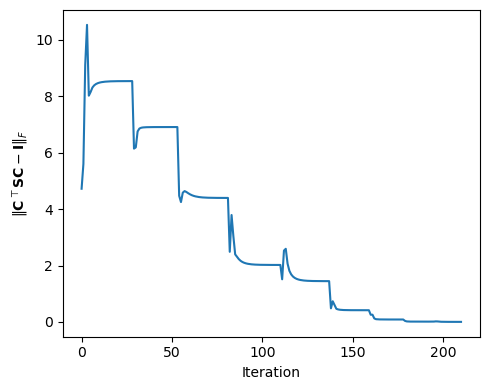

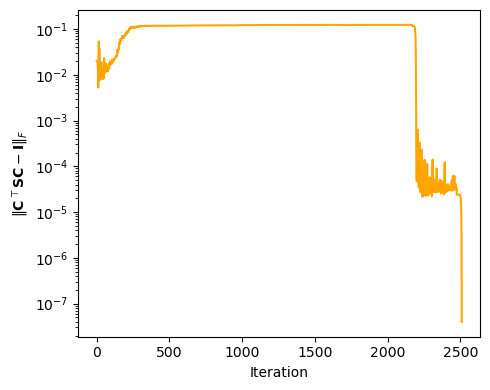

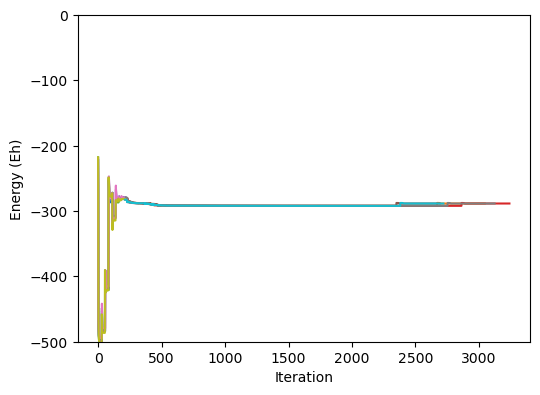

In [6]:
# Plot 1: Secant Phase Constraint (linear)
fig1, ax1 = plt.subplots(figsize=(5, 4))
ax1.plot(range(len(secant_constraints)), secant_constraints)
ax1.set_xlabel('Iteration')
ax1.set_ylabel(r'$\|\mathbf{C}^\top \mathbf{S} \mathbf{C} - \mathbf{I}\|_F$')
#ax1.set_title('Constraint (Secant Phase)')
#ax1.legend()
plt.tight_layout()
#plt.savefig("secant_constraint.eps", bbox_inches='tight')
#plt.close(fig1)

# Plot 2: Trust-Region Phase Constraint (log scale)
fig2, ax2 = plt.subplots(figsize=(5, 4))
ax2.plot(range(len(bfgs_constraints)), bfgs_constraints, color='orange')
ax2.set_yscale('log', base=10)
ax2.set_xlabel('Iteration')
ax2.set_ylabel(r'$\|\mathbf{C}^\top \mathbf{S} \mathbf{C} - \mathbf{I}\|_F$')
#ax2.set_title('Constraint (L-BFGS Phase)')
#ax2.legend()
plt.tight_layout()
#plt.savefig("bfgs_constraint.eps", bbox_inches='tight')
#plt.close(fig2)

# Plot 3: Energy Convergence
fig3, ax3 = plt.subplots(figsize=(5.5, 4))
for i, res in enumerate(results):
    secant_energies = res["secant_energies"]
    bfgs_energies = res["bfgs_energies"]

    it_sec = list(range(len(secant_energies)))
    it_bfgs = [j + len(secant_energies) for j in range(len(bfgs_energies))]

    ax3.plot(it_sec, secant_energies)
    ax3.plot(it_bfgs, bfgs_energies)

ax3.set_xlabel('Iteration')
ax3.set_ylabel('Energy (Eh)')
#ax3.set_title('Energy Convergence')
#ax3.legend()
plt.tight_layout()
plt.ylim(-500,0)
plt.show
#plt.savefig("energy_convergence.eps", bbox_inches='tight')
#plt.close(fig3)